In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'parkjaeyoung' # username
os.environ['KAGGLE_KEY'] = '4c16bfdb89a9449e8972bbc76d2f95aa' # key

In [2]:

!kaggle datasets download -d moltean/fruits


  0%|          | 0.00/760M [00:00<?, ?B/s]
  0%|          | 1.00M/760M [00:00<01:25, 9.31MB/s]
  0%|          | 3.00M/760M [00:00<01:26, 9.16MB/s]
  1%|          | 4.00M/760M [00:00<01:25, 9.31MB/s]
  1%|          | 6.00M/760M [00:00<01:12, 10.8MB/s]
  1%|1         | 8.00M/760M [00:00<01:11, 11.0MB/s]
  1%|1         | 10.0M/760M [00:01<03:23, 3.86MB/s]
  2%|1         | 12.0M/760M [00:02<02:37, 4.98MB/s]
  2%|1         | 14.0M/760M [00:02<02:05, 6.25MB/s]
  2%|2         | 16.0M/760M [00:02<01:47, 7.29MB/s]
  2%|2         | 17.0M/760M [00:03<03:06, 4.18MB/s]
  3%|2         | 19.0M/760M [00:03<02:24, 5.38MB/s]
  3%|2         | 21.0M/760M [00:03<01:57, 6.57MB/s]
  3%|2         | 22.0M/760M [00:03<01:49, 7.06MB/s]
  3%|3         | 24.0M/760M [00:03<01:32, 8.30MB/s]
  3%|3         | 26.0M/760M [00:04<01:24, 9.15MB/s]
  4%|3         | 28.0M/760M [00:04<01:19, 9.71MB/s]
  4%|3         | 30.0M/760M [00:04<01:14, 10.2MB/s]
  4%|4         | 32.0M/760M [00:04<01:11, 10.7MB/s]
  4%|4         | 34.

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [5]:
# Datagen
train_datagen = ImageDataGenerator(
  rescale=1./255, # 일반화
  rotation_range=10, # 랜덤하게 이미지를 회전 (단위: 도, 0-180)
  zoom_range=0.1, # 랜덤하게 이미지 확대 (%)
  width_shift_range=0.1,  # 랜덤하게 이미지를 수평으로 이동 (%)
  height_shift_range=0.1,  # 랜덤하게 이미지를 수직으로 이동 (%)
  horizontal_flip=True # 랜덤하게 이미지를 수평으로 뒤집기
)

test_datagen = ImageDataGenerator(
  rescale=1./255 # 일반화
)

#flow_from_directory

train_gen = train_datagen.flow_from_directory(
  'fruits-360/Training',
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical',
  shuffle=True
)

test_gen = test_datagen.flow_from_directory(
  'fruits-360/Test',
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical',
  shuffle=False
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [6]:
from pprint import pprint
pprint(train_gen.class_indices)

{'Apple Braeburn': 0,
 'Apple Crimson Snow': 1,
 'Apple Golden 1': 2,
 'Apple Golden 2': 3,
 'Apple Golden 3': 4,
 'Apple Granny Smith': 5,
 'Apple Pink Lady': 6,
 'Apple Red 1': 7,
 'Apple Red 2': 8,
 'Apple Red 3': 9,
 'Apple Red Delicious': 10,
 'Apple Red Yellow 1': 11,
 'Apple Red Yellow 2': 12,
 'Apricot': 13,
 'Avocado': 14,
 'Avocado ripe': 15,
 'Banana': 16,
 'Banana Lady Finger': 17,
 'Banana Red': 18,
 'Beetroot': 19,
 'Blueberry': 20,
 'Cactus fruit': 21,
 'Cantaloupe 1': 22,
 'Cantaloupe 2': 23,
 'Carambula': 24,
 'Cauliflower': 25,
 'Cherry 1': 26,
 'Cherry 2': 27,
 'Cherry Rainier': 28,
 'Cherry Wax Black': 29,
 'Cherry Wax Red': 30,
 'Cherry Wax Yellow': 31,
 'Chestnut': 32,
 'Clementine': 33,
 'Cocos': 34,
 'Corn': 35,
 'Corn Husk': 36,
 'Cucumber Ripe': 37,
 'Cucumber Ripe 2': 38,
 'Dates': 39,
 'Eggplant': 40,
 'Fig': 41,
 'Ginger Root': 42,
 'Granadilla': 43,
 'Grape Blue': 44,
 'Grape Pink': 45,
 'Grape White': 46,
 'Grape White 2': 47,
 'Grape White 3': 48,
 'Grap

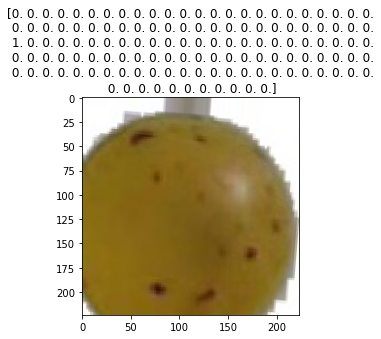

In [7]:
preview_batch = train_gen.__getitem__(0)

preview_imgs, preview_labels = preview_batch

plt.title(str(preview_labels[0]))
plt.imshow(preview_imgs[0])

# 전이학습
https://keras.io/api/applications/

In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

input = Input(shape=(224, 224, 3))

base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input, pooling='max')

x = base_model.output #출력을 자유롭게 사용할 것이다
x = Dropout(rate=0.25)(x)
x = Dense(256, activation='relu')(x)
output = Dense(131, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

87916544/87910968 [==============================] - 8s 0us/step


In [9]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=20, # epochs 복수형으로 쓰기!
    callbacks=[
      ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)  # 검증 데이터를 넣어주면 한 epoch이 끝날때마다 자동으로 검증
    ]
)
#노트북으로 한 epoch당 3시간 걸림

Epoch 1/20
  15/2116 [..............................] - ETA: 3:37:42 - loss: 5.4357 - acc: 0.0167

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (20,6))

axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[1].plot(history.history['acc'])
axes[1].plot(history.history['val_acc'])


# 학습된 모델 로딩

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')

# 결과값확인

In [ ]:
#100개의 값을 얻는다 
test_imgs, test_labels = test_gen.__getitem__(100)

y_pred = model.predict(test_imgs)

#이름으로 저장된 classes
classes = dict((v, k) for k, v in test_gen.class_indices.items())

fig, axes = plt.subplots(4, 8, figsize=(20, 12))

for img, test_label, pred_label, ax in zip(test_imgs, test_labels, y_pred, axes.flatten()):
  test_label = classes[np.argmax(test_label)]
  pred_label = classes[np.argmax(pred_label)]

  ax.set_title('GT:%s\nPR:%s' % (test_label, pred_label))
  ax.imshow(img)